In [7]:
import numpy as np
import matplotlib.pyplot as plt

## Solving for the optimal exercise boundary

### The Integral Equation

$$
S_f(t) - K = M_1(S_f(t), T-t, K) + \int_t^{T}Q_1(S_f(t), t, u, S_f(u)) du
$$

$$
Q_1(x,y,z,w) = x\delta e^{-\delta(z - y)} \Phi(d_1(x, z-y, w))
- rKe^{-r(z-y)}\Phi(d_2(x, z-y, w))
$$

$$
M_1(x,y,z) = xe^{-\delta y} \Phi (d_1(x,y,z)) - z e^{-ry}\Phi(d_2(x,y,z))
$$

$$
d_1(x, y, z) = \frac{\ln(x/z) + (r - \delta + \sigma^2/2)y}{\sigma\sqrt{y}}
$$

$$
d_2(x, y, z) = d_1(x,y,z)-\sigma\sqrt{y}
$$

$$
1_{(S=S_f)}(S) =
\begin{cases}
\frac{1}{2} & \textrm{if } S = S_f(t) \\ 
0 & \textrm{otherwise}
\end{cases}
$$

### Parameters

In [2]:
dividend = 0.02
strike_price = 100
volatility = 0.2
risk_free_rate = 0.05
time_to_maturity = 1

### Computation of necessary functions

In [3]:
from scipy.special import erf

# The CDF of the standard normal distribution
def phi(z):
    return (1.0 + erf(z / np.sqrt(2.0))) / 2.0

def d1(x, y, z):
    return (np.log(x / z) + (risk_free_rate - dividend + volatility ** 2 / 2) * y) / (volatility * np.sqrt(y))

def d2(x, y, z):
    return d1(x, y, z) - volatility * np.sqrt(y)

def Q1(x, y, z, w):
    x = float(x)
    result = x * dividend * np.exp(-dividend * (z - y)) * phi(d1(x, z - y, w))
    result -= risk_free_rate * strike_price * np.exp(-risk_free_rate * (z - y)) * phi(d2(x, z - y, w))
    return result

def Q1_derivative_x(x, y, z, w):
    # Derivative of Q1 with respect to x using five-point stencil method
    h = 1e-5
    return (-Q1(x + 2*h, y, z, w) + 8*Q1(x + h, y, z, w) - 8*Q1(x - h, y, z, w) + Q1(x - 2*h, y, z, w)) / (12 * h)

def M1(x, y, z):
    x = float(x)
    result = x * np.exp(-dividend * y) * phi(d1(x, y, z)) - strike_price * np.exp(-risk_free_rate * y) * phi(d2(x, y, z))
    return result

def M1_derivative_x(x, y, z):
    # Derivative of M1 with respect to x using five-point stencil method
    h = 1e-5
    return (-M1(x + 2*h, y, z) + 8*M1(x + h, y, z) - 8*M1(x - h, y, z) + M1(x - 2*h, y, z)) / (12 * h)

### The Newton Raphson procedure

In [18]:
# Newton-Raphson method
def newton_raphson(f, f_prime, x0, tol=1e-8, max_iter=100):
    x = x0
    n_iter = 0
    for _ in range(max_iter):
        n_iter += 1
        fx = f(x)
        fpx = f_prime(x)
        if abs(fpx) < tol:
            raise ValueError("Derivative too small; no convergence.")
        x_new = x - fx / fpx
        if abs(x_new - x) < tol:
            return [x_new, n_iter]
        x = x_new
    print(f"Did not converge in {max_iter} iterations.")
    return [x, n_iter]

### Computing the solution

In [19]:
time_discretization = np.linspace(0, time_to_maturity, 252)
s_f_list = []
s_f_list.append([0] * len(time_discretization))
s_f_list = s_f_list[0]

s_f_list[-1] = max(strike_price, risk_free_rate * strike_price / dividend)
n_steps = len(time_discretization) - 1
cnt=0
n_steps_to_convergence = []
for i in range(len(time_discretization) - 2, -1, -1):
    time_passed = i / n_steps
    guess_x = s_f_list[i + 1] 
    def test_sf(x):
        test_result =  x - strike_price - M1(x, 1-time_passed, strike_price)
        test_result -= (1/(n_steps * 2)) * Q1(x, time_passed, time_passed + 1.0/n_steps, s_f_list[i + 1])
        test_result -= (1/(n_steps * 2)) * (1/2 * x * dividend - 1/2 * risk_free_rate * strike_price)
        for j in range(i + 1, len(time_discretization) - 1, 1):
            test_result -= (1/(n_steps * 2)) * Q1(x, time_passed, j/n_steps, s_f_list[j])
            test_result -= (1/(n_steps * 2)) * Q1(x, time_passed, (j + 1)/n_steps, s_f_list[j + 1])
        return test_result
    def test_sf_derivative(x):
        derivative_result = 1 - M1_derivative_x(x, 1 - time_passed, strike_price)
        derivative_result -= (1/(n_steps*2)) * Q1_derivative_x(x, time_passed, time_passed + 1.0/n_steps, s_f_list[i + 1])
        derivative_result -= (1/(n_steps*2)) * 1/2 * dividend
        for j in range(i + 1, len(time_discretization) - 1):
            derivative_result -= (1/(n_steps * 2)) * Q1_derivative_x(x, time_passed, j/n_steps, s_f_list[j])
            derivative_result -= (1/(n_steps * 2)) * Q1_derivative_x(x, time_passed, (j + 1)/n_steps, s_f_list[j + 1])
        return derivative_result
    
    newton_raphson_result = newton_raphson(test_sf, test_sf_derivative, guess_x)
    s_f_list[i] = newton_raphson_result[0]
    n_steps_to_convergence.append(newton_raphson_result[1])

Text(0.5, 0, 'Time (Maturity = 1)')

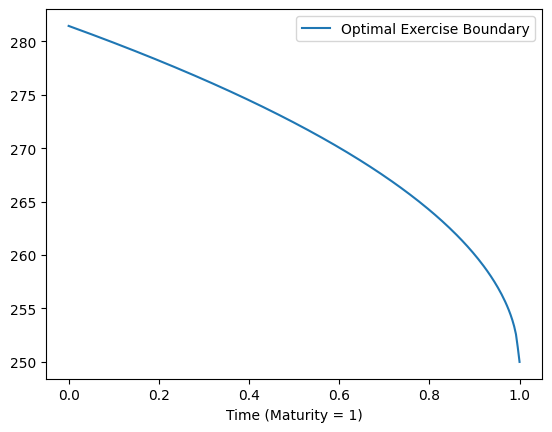

In [20]:
# Graph the stock price and the optimal exercise boundary
plt.plot(time_discretization, s_f_list, label='Optimal Exercise Boundary')
plt.legend()
plt.xlabel('Time (Maturity = 1)')

## Convergence analysis

Here, we plot the distribution of the number of steps needed for Newton Raphson procedures to converge.

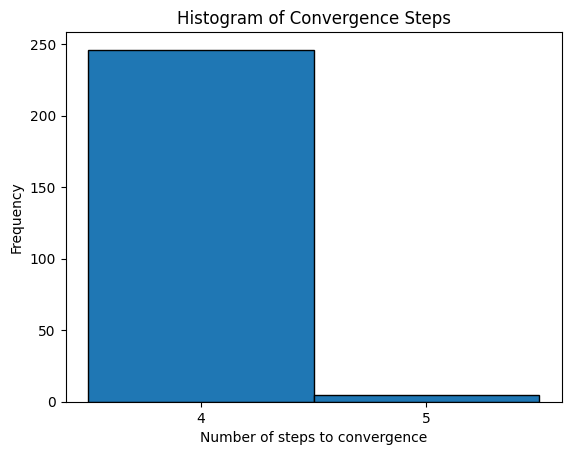

In [26]:
# Convert n_steps_to_convergence to a NumPy array
n_steps_to_convergence_array = np.array(n_steps_to_convergence)

# Assuming n_steps_to_convergence is a NumPy array of integer values:
min_val = n_steps_to_convergence_array.min()
max_val = n_steps_to_convergence_array.max()

# Create bins that cover each integer value. The -0.5 and +0.5 ensure that the bin is centered on the integer.
bins = np.arange(min_val - 0.5, max_val + 1.5, 1)

plt.hist(n_steps_to_convergence_array, bins=bins, edgecolor='black')
plt.xticks(np.arange(min_val, max_val + 1))  # Set x-ticks to integer values
plt.xlabel('Number of steps to convergence')
plt.ylabel('Frequency')
plt.title('Histogram of Convergence Steps')
plt.show()

In qualitative terms, quadratic convergence means that each iteration typically doubles the number of correct digits. Since our tolerance is set at $10^{-8}$, about four iterations are required to achieve this level of precision, which strongly indicates that our convergence is indeed quadratic.

### What if the number of discretization decreases?

In [47]:
time_discretization = np.linspace(0, time_to_maturity, 3)
s_f_list = []
s_f_list.append([0] * len(time_discretization))
s_f_list = s_f_list[0]

s_f_list[-1] = max(strike_price, risk_free_rate * strike_price / dividend)
n_steps = len(time_discretization) - 1
cnt=0
n_steps_to_convergence = []
for i in range(len(time_discretization) - 2, -1, -1):
    time_passed = i / n_steps
    guess_x = s_f_list[i + 1] 
    def test_sf(x):
        test_result =  x - strike_price - M1(x, 1-time_passed, strike_price)
        test_result -= (1/(n_steps * 2)) * Q1(x, time_passed, time_passed + 1.0/n_steps, s_f_list[i + 1])
        test_result -= (1/(n_steps * 2)) * (1/2 * x * dividend - 1/2 * risk_free_rate * strike_price)
        for j in range(i + 1, len(time_discretization) - 1, 1):
            test_result -= (1/(n_steps * 2)) * Q1(x, time_passed, j/n_steps, s_f_list[j])
            test_result -= (1/(n_steps * 2)) * Q1(x, time_passed, (j + 1)/n_steps, s_f_list[j + 1])
        return test_result
    def test_sf_derivative(x):
        derivative_result = 1 - M1_derivative_x(x, 1 - time_passed, strike_price)
        derivative_result -= (1/(n_steps*2)) * Q1_derivative_x(x, time_passed, time_passed + 1.0/n_steps, s_f_list[i + 1])
        derivative_result -= (1/(n_steps*2)) * 1/2 * dividend
        for j in range(i + 1, len(time_discretization) - 1):
            derivative_result -= (1/(n_steps * 2)) * Q1_derivative_x(x, time_passed, j/n_steps, s_f_list[j])
            derivative_result -= (1/(n_steps * 2)) * Q1_derivative_x(x, time_passed, (j + 1)/n_steps, s_f_list[j + 1])
        return derivative_result
    
    newton_raphson_result = newton_raphson(test_sf, test_sf_derivative, guess_x)
    s_f_list[i] = newton_raphson_result[0]
    n_steps_to_convergence.append(newton_raphson_result[1])

Text(0.5, 0, 'Time (Maturity = 1)')

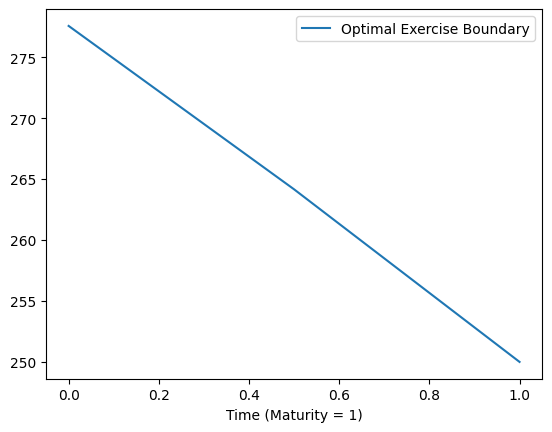

In [48]:
# Graph the stock price and the optimal exercise boundary
plt.plot(time_discretization, s_f_list, label='Optimal Exercise Boundary')
plt.legend()
plt.xlabel('Time (Maturity = 1)')

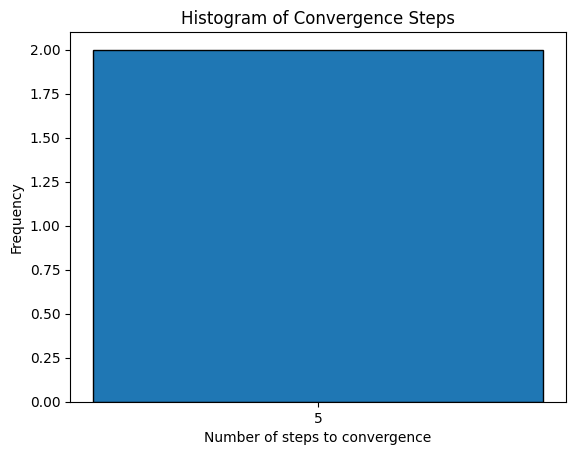

In [49]:
# Convert n_steps_to_convergence to a NumPy array
n_steps_to_convergence_array = np.array(n_steps_to_convergence)

# Assuming n_steps_to_convergence is a NumPy array of integer values:
min_val = n_steps_to_convergence_array.min()
max_val = n_steps_to_convergence_array.max()

# Create bins that cover each integer value. The -0.5 and +0.5 ensure that the bin is centered on the integer.
bins = np.arange(min_val - 0.5, max_val + 1.5, 1)

plt.hist(n_steps_to_convergence_array, bins=bins, edgecolor='black')
plt.xticks(np.arange(min_val, max_val + 1))  # Set x-ticks to integer values
plt.xlabel('Number of steps to convergence')
plt.ylabel('Frequency')
plt.title('Histogram of Convergence Steps')
plt.show()

As we can see, even the number of discretization is 3, the Newton Raphson still converges. This means that even when the distance between the root and the initial guess is super far, we still have convergence (perhaps even quadratic). Therefore, it is likely that the function $f$ that we are finding the root has very nice property

### The plot of $f$

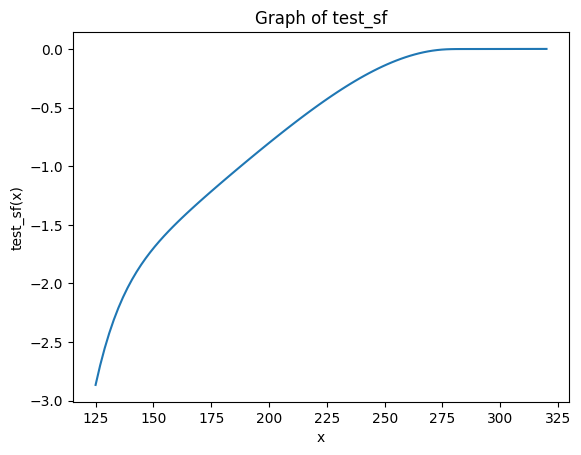

In [63]:
time_discretization = np.linspace(0, time_to_maturity, 200)
s_f_list = []
s_f_list.append([0] * len(time_discretization))
s_f_list = s_f_list[0]

s_f_list[-1] = max(strike_price, risk_free_rate * strike_price / dividend)
n_steps = len(time_discretization) - 1
cnt=0
n_steps_to_convergence = []
for i in range(len(time_discretization) - 2, -1, -1):
    time_passed = i / n_steps
    guess_x = s_f_list[i + 1] 
    def test_sf(x):
        test_result =  x - strike_price - M1(x, 1-time_passed, strike_price)
        test_result -= (1/(n_steps * 2)) * Q1(x, time_passed, time_passed + 1.0/n_steps, s_f_list[i + 1])
        test_result -= (1/(n_steps * 2)) * (1/2 * x * dividend - 1/2 * risk_free_rate * strike_price)
        for j in range(i + 1, len(time_discretization) - 1, 1):
            test_result -= (1/(n_steps * 2)) * Q1(x, time_passed, j/n_steps, s_f_list[j])
            test_result -= (1/(n_steps * 2)) * Q1(x, time_passed, (j + 1)/n_steps, s_f_list[j + 1])
        return test_result
    def test_sf_derivative(x):
        derivative_result = 1 - M1_derivative_x(x, 1 - time_passed, strike_price)
        derivative_result -= (1/(n_steps*2)) * Q1_derivative_x(x, time_passed, time_passed + 1.0/n_steps, s_f_list[i + 1])
        derivative_result -= (1/(n_steps*2)) * 1/2 * dividend
        for j in range(i + 1, len(time_discretization) - 1):
            derivative_result -= (1/(n_steps * 2)) * Q1_derivative_x(x, time_passed, j/n_steps, s_f_list[j])
            derivative_result -= (1/(n_steps * 2)) * Q1_derivative_x(x, time_passed, (j + 1)/n_steps, s_f_list[j + 1])
        return derivative_result
    
    if (i == 30):
        # Plot the graph of test_sf
        x_values = np.linspace(125, 320, 100)
        y_values = [test_sf(x) for x in x_values]
        plt.plot(x_values, y_values)
        plt.xlabel('x')
        plt.ylabel('test_sf(x)')
        plt.title('Graph of test_sf')
        plt.show()
        break
    newton_raphson_result = newton_raphson(test_sf, test_sf_derivative, guess_x)
    s_f_list[i] = newton_raphson_result[0]
    n_steps_to_convergence.append(newton_raphson_result[1])

We can clearly see that our function $f$ is concave.